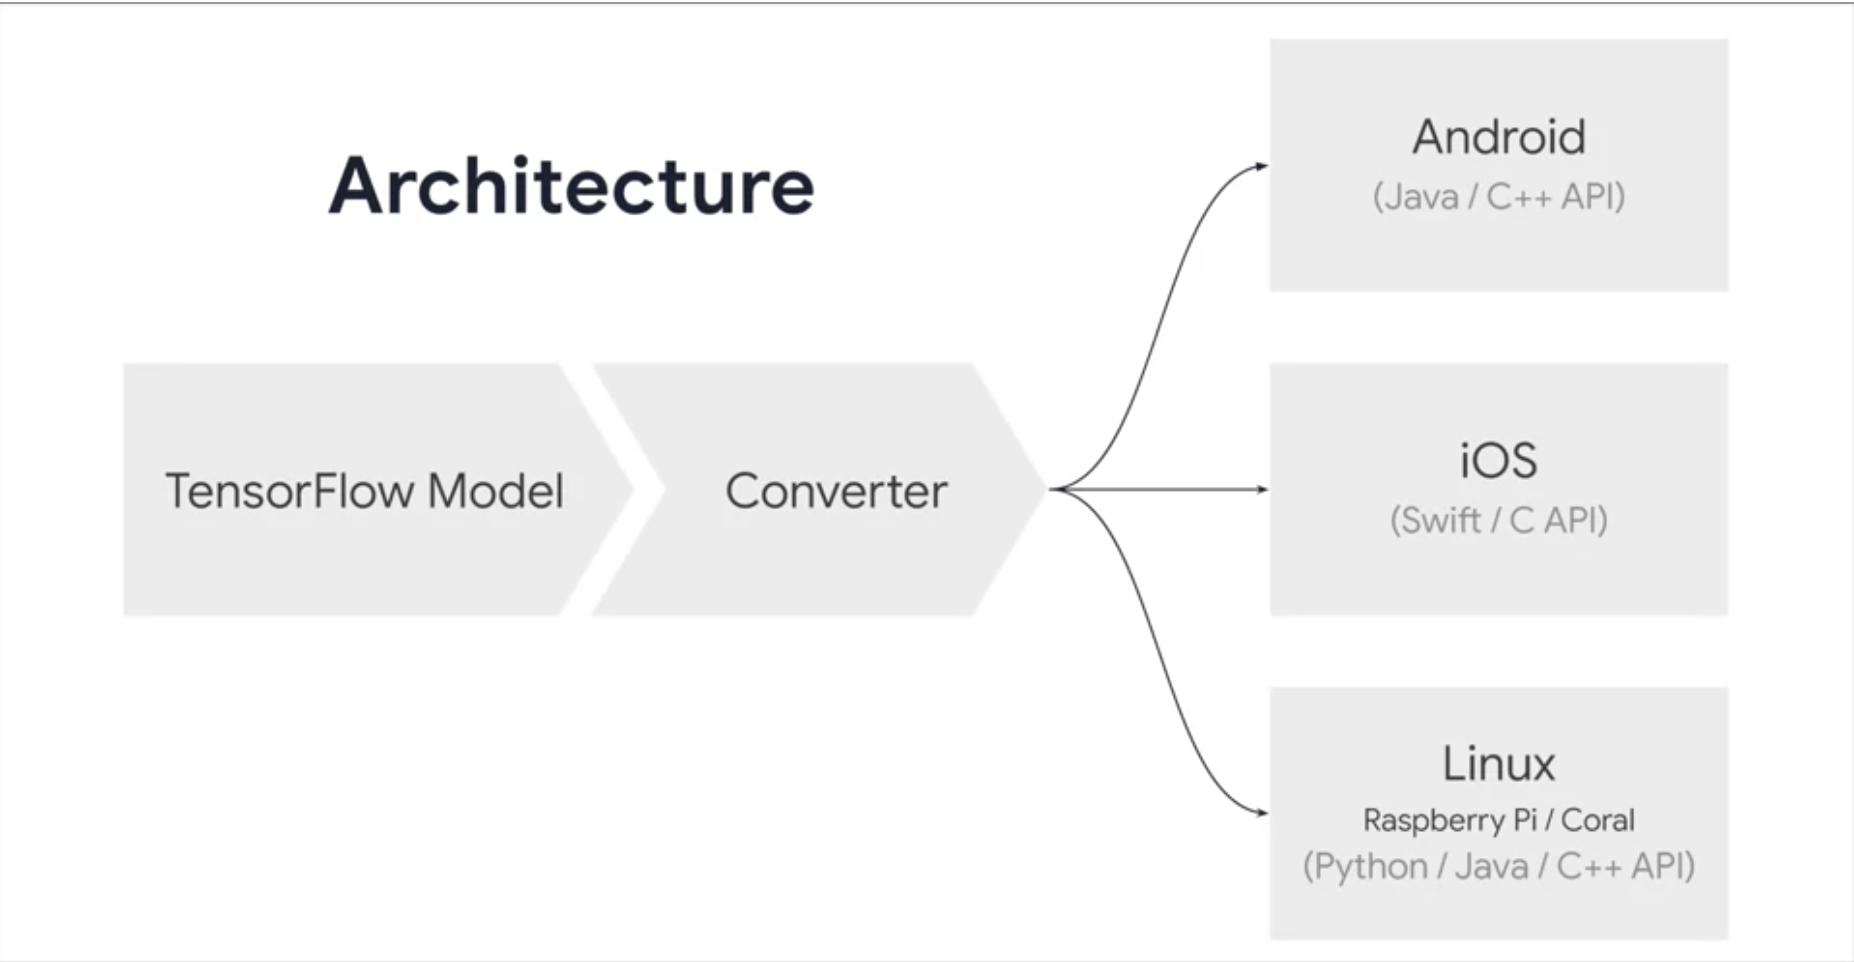

In [34]:
#Architecture

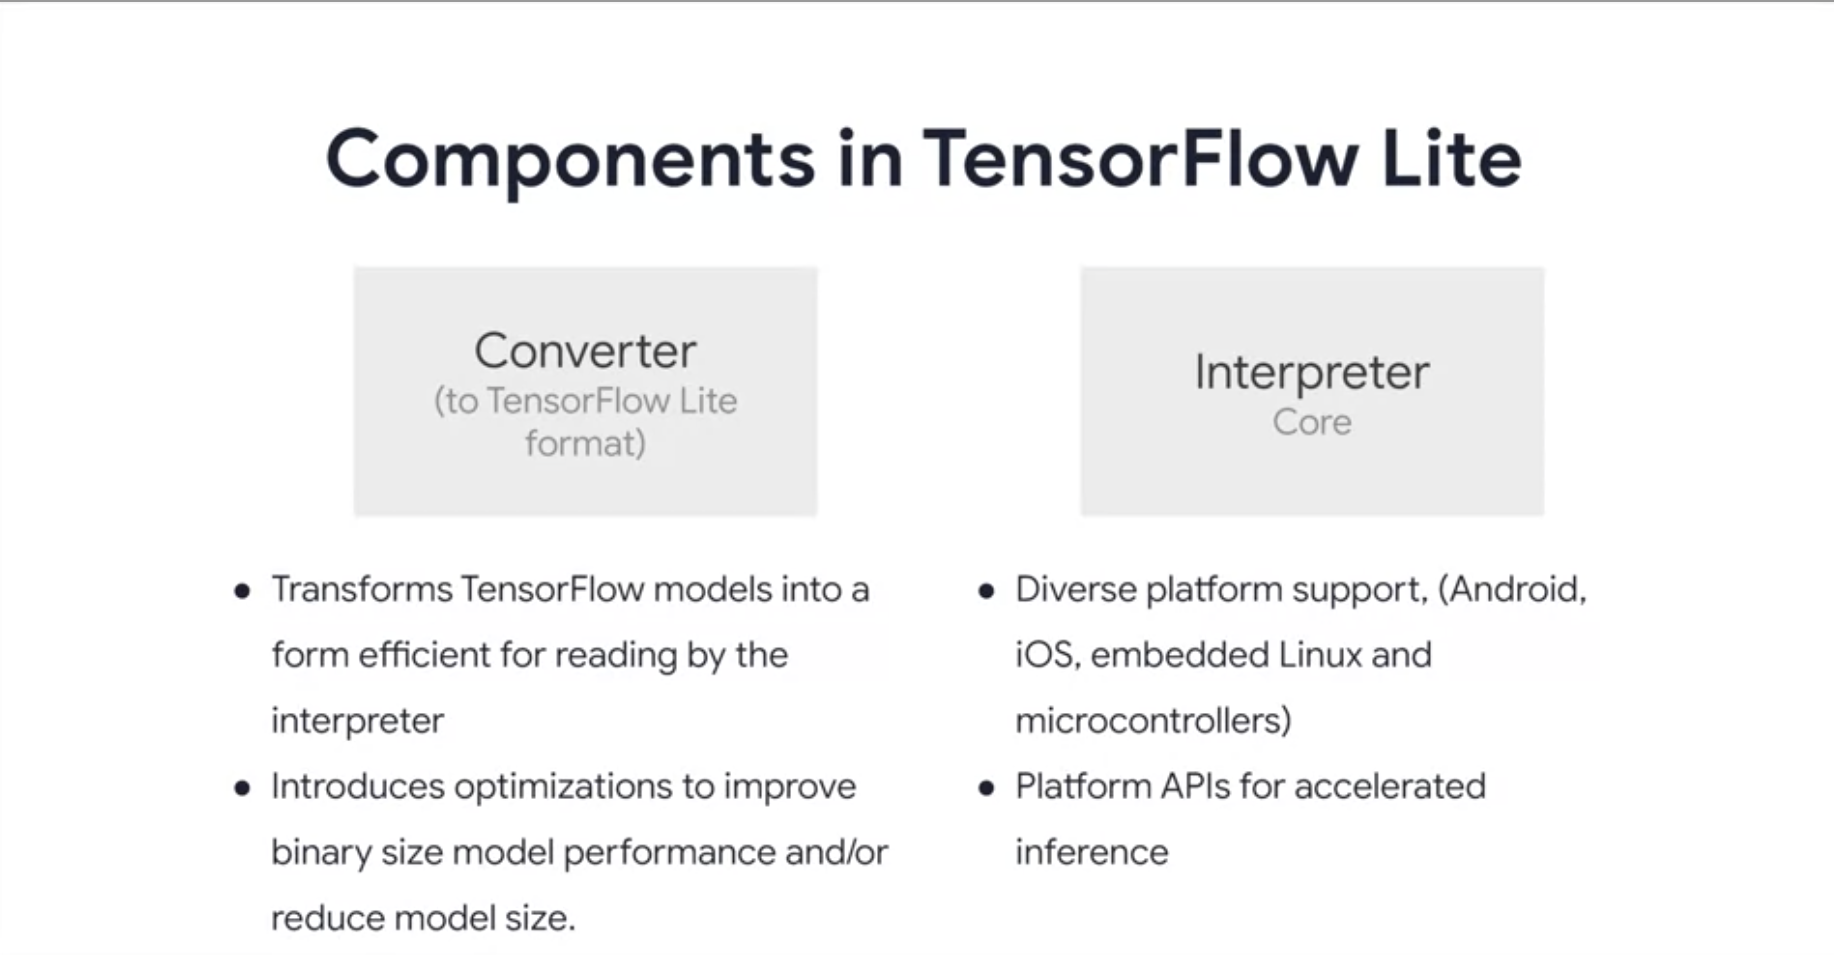

In [33]:
#TFLte Components

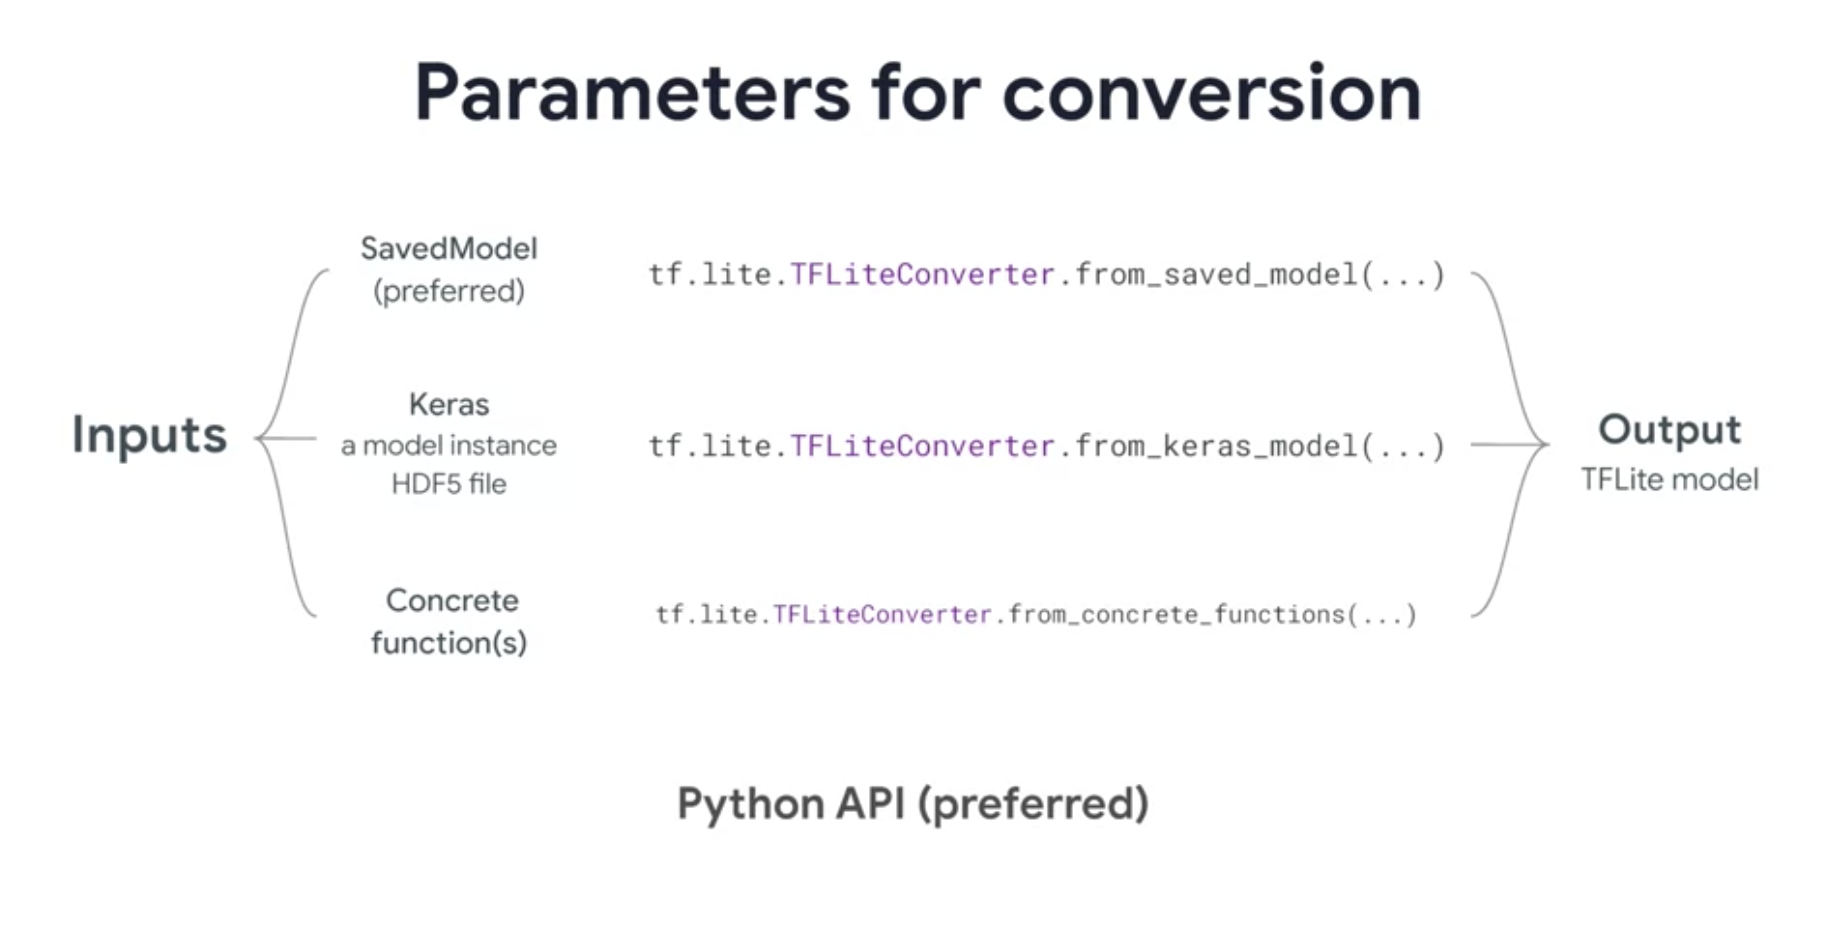

In [37]:
#Conversion parameters

In [5]:
# Load the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [6]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'

Let's generate some data.

In [7]:
# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

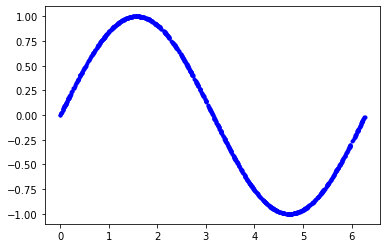

In [8]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers 
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

Let's add some noise our data.

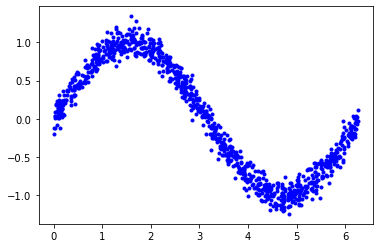

In [9]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

Next, let's split our data. 

The data is split as follows:

    Training: 60%
    Validation: 20%
    Testing: 20%

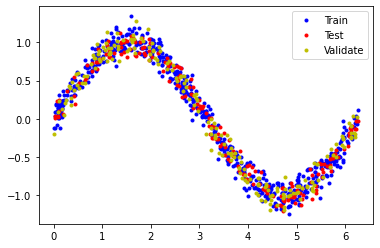

In [10]:
# Set the indices for data split We'll use 60% of our data for training and 20% for testing, and  the remaining 20%
# will be used for validation. 
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Split the data intro train, test, and validation.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


Create and train the model.

In [11]:
#Let's try training a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss="mse", metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

In [23]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(6, 4))

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [24]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

In [25]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

Quantization

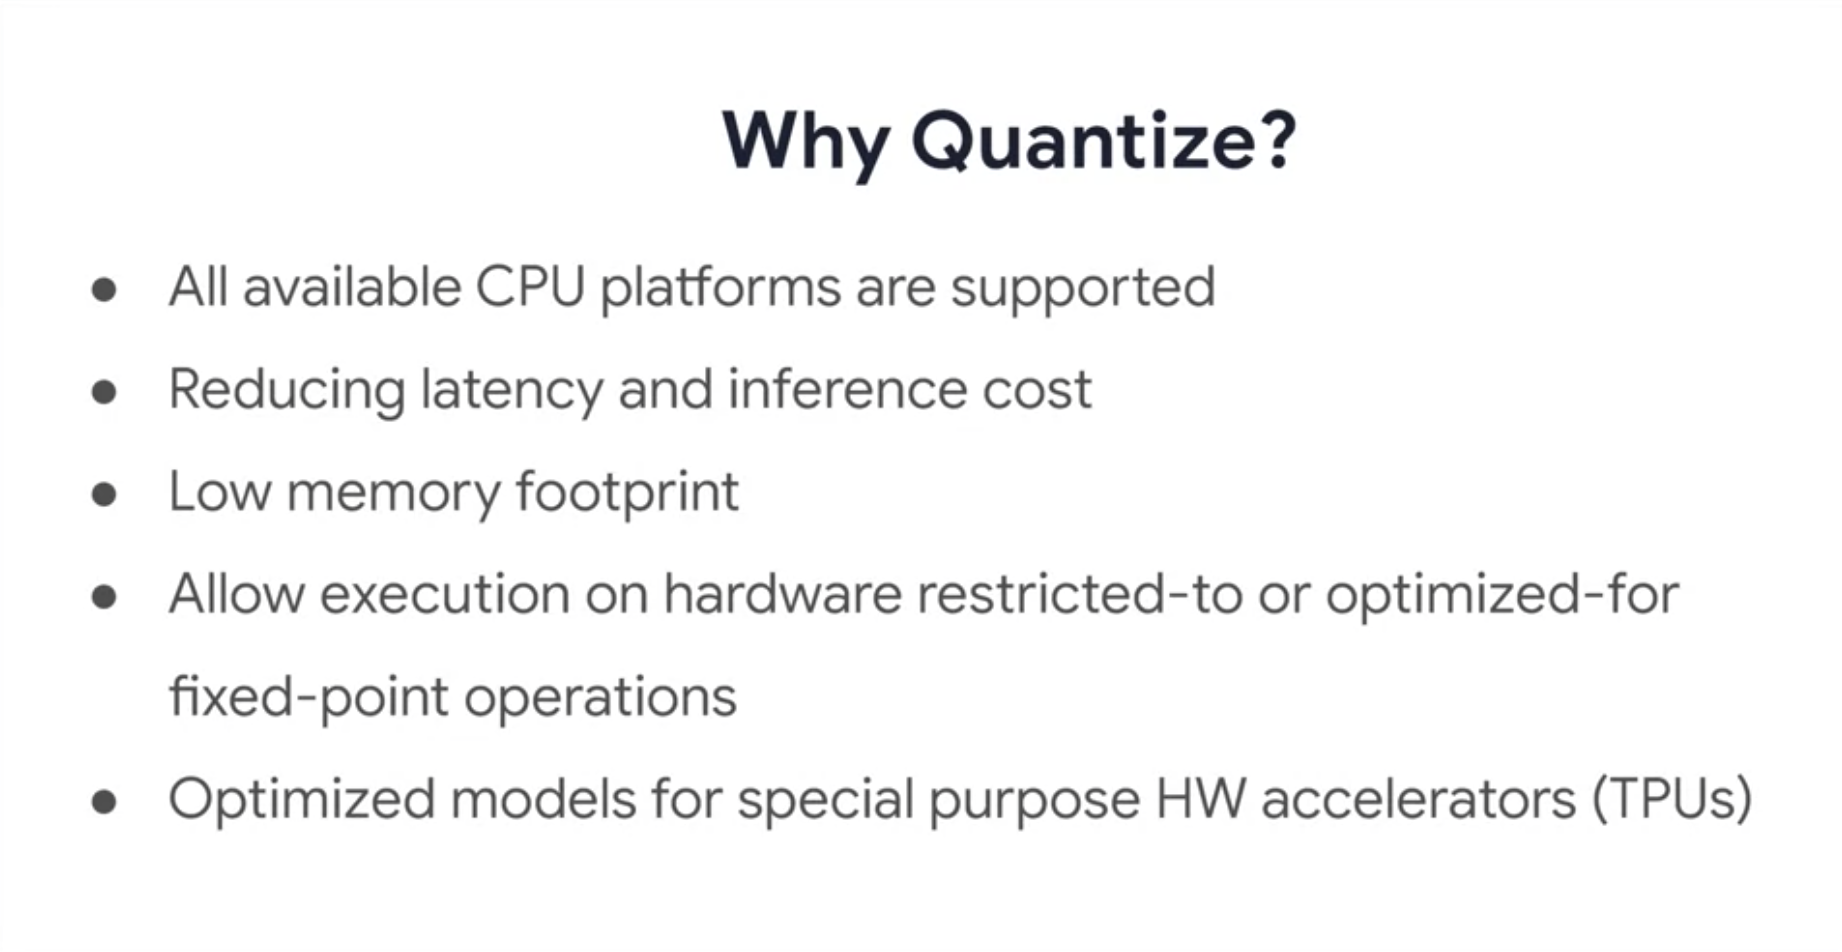

In [36]:
#Benefits of model quantization

In [26]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
    for i in range(500):
        yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

Inference and evaluation

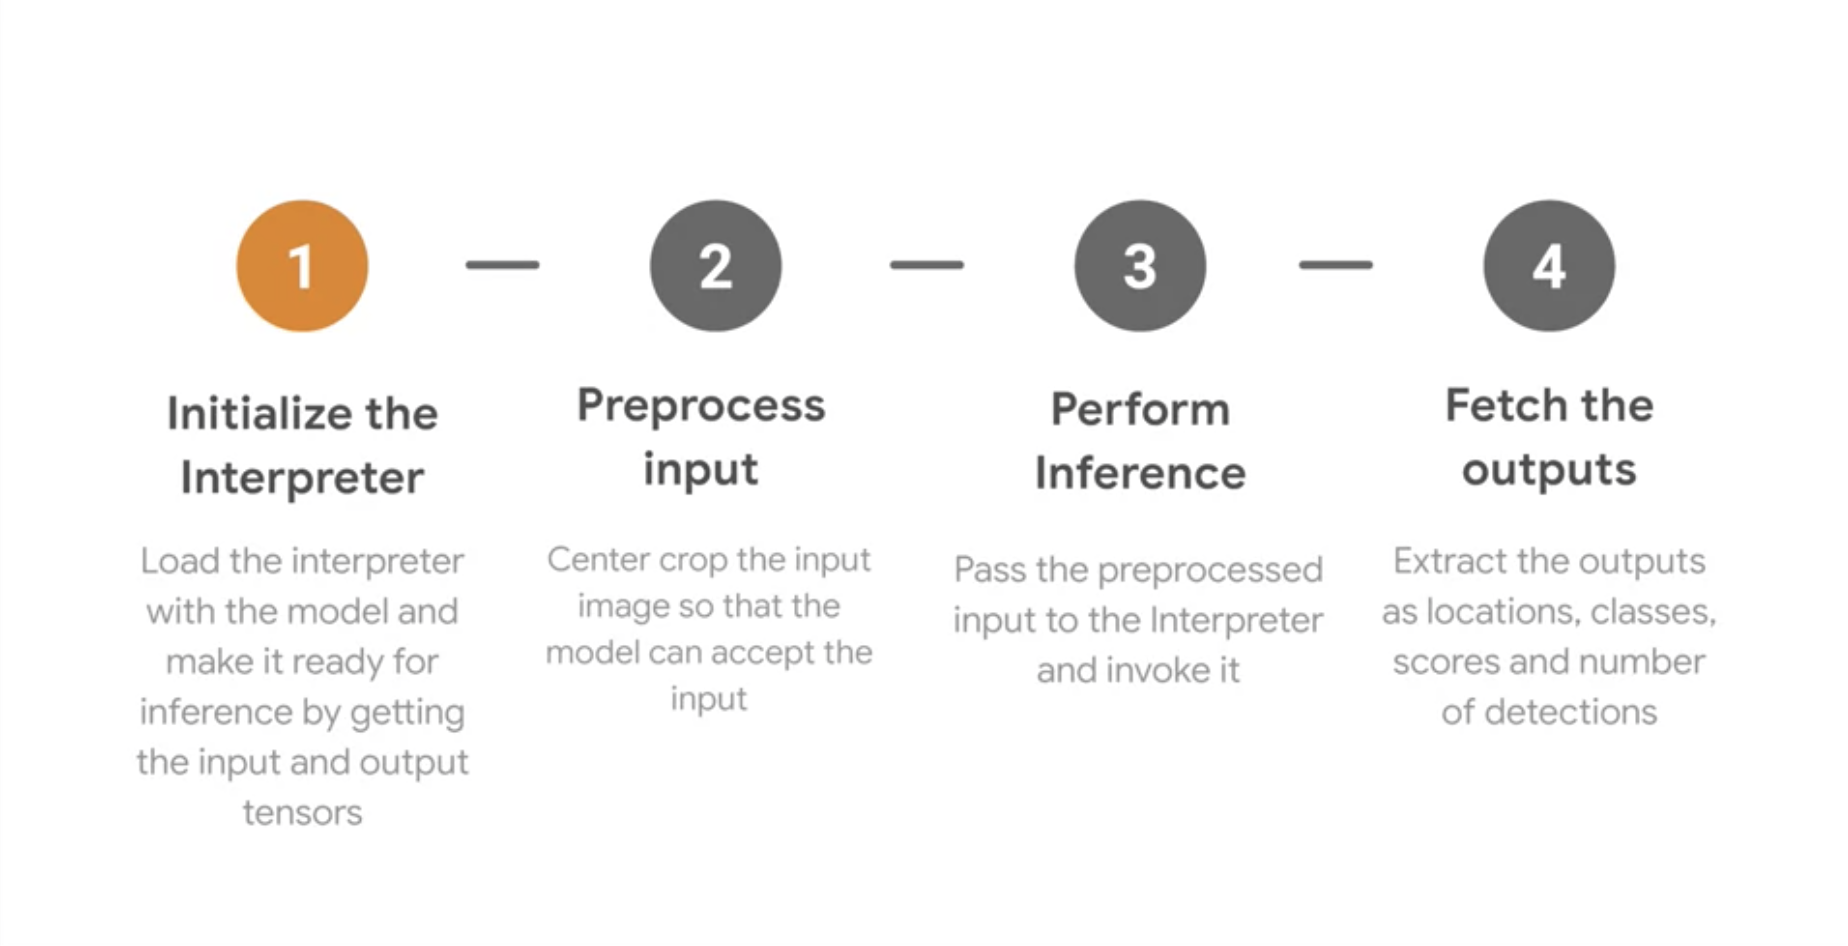

In [32]:
#Inference pipeline

In [72]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

  # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
    global model
    y_pred = predict_tflite(tflite_model, x_test)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).numpy()
    return loss

In [73]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

In [27]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

In [75]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [28]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

In [77]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [29]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")